### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [8]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/jy/p0rys3xs3xq9q6p04m4b49_80000gn/T/ipykernel_2234/3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("Provide me the recent AI news for Feb 9th 2025 and also provide the source link for the news")

[{'title': 'AI news and Funding updates 9 February 2025 | Anshuman Jha',
  'url': 'https://www.linkedin.com/posts/anshuman-jha-0891bb1a4_ai-news-and-funding-updates-9-february-2025-activity-7294389133370630144-hZWA',
  'content': "Join the conversation! Share your thoughts and engage with others passionate about AI and technology. Let's explore how we can harness these innovations for a better future.\n👉 Read the full article here and share your insights!\nSource link [...] AI news and funding updates from the last 24 hours(9th Feb 2025):\n💥 AI News\n✅ Chinese Companies Embrace DeepSeek AI: Chinese automaker Great Wall Motor Co., Ltd. and leading telecom providers are integrating DeepSeek AI's AI model into their offerings, aiming to capitalize on the startup's advancements.\n✅ AI Summit in Paris: A major summit in Paris, co-hosted by French President Emmanuel Macron and Indian Prime Minister Narendra Modi, is focusing on guiding AI development responsibly. The event gathers world lead

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [14]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'htjyhg2cj', 'function': {'arguments': '{"query":"Recent AI News"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 553, 'total_tokens': 573, 'completion_time': 0.040529812, 'completion_tokens_details': None, 'prompt_time': 0.038042295, 'prompt_tokens_details': None, 'queue_time': 0.107353765, 'total_time': 0.078572107}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c40f5-69bf-7220-aac9-7591b46ad3ea-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent AI News'}, 'id': 'htjyhg2cj', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 553, 'output_tokens': 20, 'total_tokens': 573})

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Recent AI News'},
  'id': 'yy4bw3yt6',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

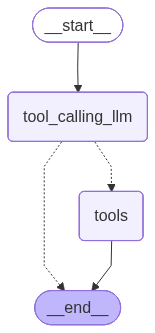

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (rseewbbwq)
 Call ID: rseewbbwq
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1ncyn18r5)
 Call ID: 1ncyn18r5
  Args:
    query: AI news March 3rd 2025 top 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The 10 Biggest AI News Stories Of 2025 - CRN", "url": "https://www.crn.com/news/ai/2025/the-10-biggest-ai-news-stories-of-2025", "content": "Google announcing in March its plan to buy Wiz for $32 billion to boost AI capabilities in its security product portfolio\n   ServiceNow unveiling in March its plan to buy Moveworks for about $3 billion to boost its AI assistant abilities\n   IBM disclosing earlier this month its plan to buy Confluent for $11 billion to aid in AI deployment through the latter’s data streaming platform\n\n